In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
encoder = keras.layers.Dense(2, input_shape=[3])
decoder = keras.layers.Dense(3, input_shape=[2])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer="sgd")

autoencoder.fit(X_train, X_train, epochs=20)

coding = autoencoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 2s 5ms/step - loss: 0.6940
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6670
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6419
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6189
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5971
Epoch 6/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5769
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5580
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5403
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5236
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5080
Epoch 11/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4931
Epoch 12/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4797
Epoch 13/20
2/2 [==============================] - 0s 3ms/step - loss: 0.

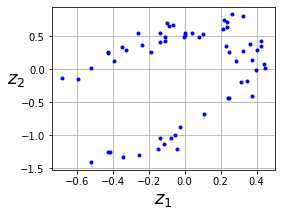

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [7]:
stacked_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

stacked_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3360 - rounded_accuracy: 0.8889 - val_loss: 0.3097 - val_rounded_accuracy: 0.9132
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3039 - rounded_accuracy: 0.9168 - val_loss: 0.2999 - val_rounded_accuracy: 0.9225
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2967 - rounded_accuracy: 0.9234 - val_loss: 0.2958 - val_rounded_accuracy: 0.9243
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2926 - rounded_accuracy: 0.9270 - val_loss: 0.2935 - val_rounded_accuracy: 0.9284
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2900 - rounded_accuracy: 0.9294 - val_loss: 0.2897 - val_rounded_accuracy: 0.9309
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2881 - rounded_accuracy: 0.9309 - val_loss: 0.2885 - val_rounded_accuracy: 0.9306
Epoch 7/10
1719/1719 [============

In [8]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [9]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

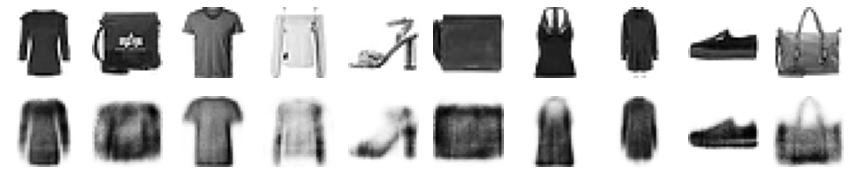

In [10]:
show_reconstructions(stacked_ae)

In [11]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


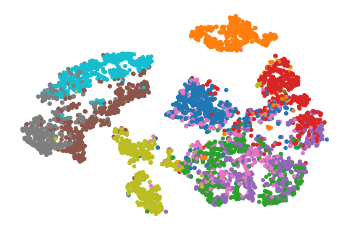

In [12]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

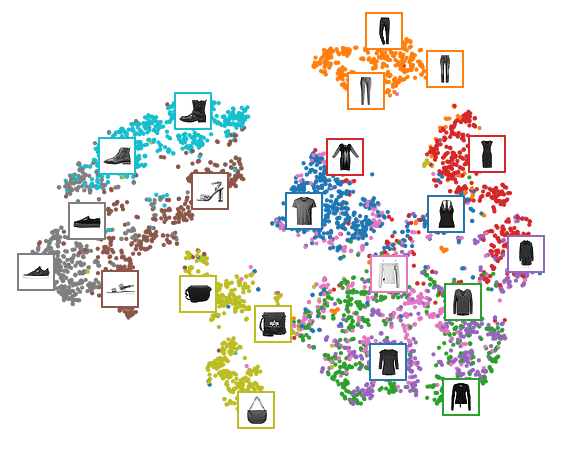

In [13]:
import matplotlib as mpl


plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [14]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_size):
        self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_size)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [15]:
keras.backend.clear_session()

dense1 = keras.layers.Dense(100, activation="selu")
dense2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    dense1,
    dense2,
])

tied_decoder = keras.models.Sequential([ 
    DenseTranspose(dense2, activation="selu"),
    DenseTranspose(dense1, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

tied_coder = keras.models.Sequential([tied_encoder, tied_decoder])

tied_coder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

tied_coder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3256 - rounded_accuracy: 0.8974 - val_loss: 0.3060 - val_rounded_accuracy: 0.9102
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2962 - rounded_accuracy: 0.9238 - val_loss: 0.2965 - val_rounded_accuracy: 0.9200
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2905 - rounded_accuracy: 0.9290 - val_loss: 0.2896 - val_rounded_accuracy: 0.9321
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2875 - rounded_accuracy: 0.9317 - val_loss: 0.2881 - val_rounded_accuracy: 0.9346
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2855 - rounded_accuracy: 0.9336 - val_loss: 0.2855 - val_rounded_accuracy: 0.9356
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2841 - rounded_accuracy: 0.9347 - val_loss: 0.2851 - val_rounded_accuracy: 0.9371
Epoch 7/10
1719/1719 [============

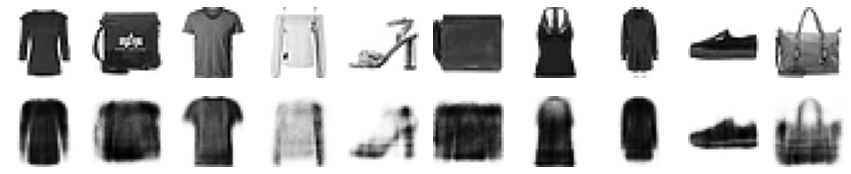

In [16]:
show_reconstructions(tied_coder)

In [17]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])

    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    
    autoencoder = keras.models.Sequential([encoder, decoder])
    
    autoencoder.compile(optimizer, loss, metrics=metrics)
    
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [18]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat, "binary_crossentropy", keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid", metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05), output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3450 - rounded_accuracy: 0.8871 - val_loss: 0.3115 - val_rounded_accuracy: 0.9157
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3030 - rounded_accuracy: 0.9211 - val_loss: 0.2999 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2945 - rounded_accuracy: 0.9289 - val_loss: 0.2932 - val_rounded_accuracy: 0.9315
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2890 - rounded_accuracy: 0.9341 - val_loss: 0.2888 - val_rounded_accuracy: 0.9357
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2853 - rounded_accuracy: 0.9376 - val_loss: 0.2857 - val_rounded_accuracy: 0.9390
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2827 - rounded_accuracy: 0.9402 - val_loss: 0.2834 - val_rounded_accuracy: 0.9410
Epoch 7/10
1719/1719 [==================

In [19]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1,
    enc2,
    dec2,
    dec1,
    keras.layers.Reshape([28, 28]),
])

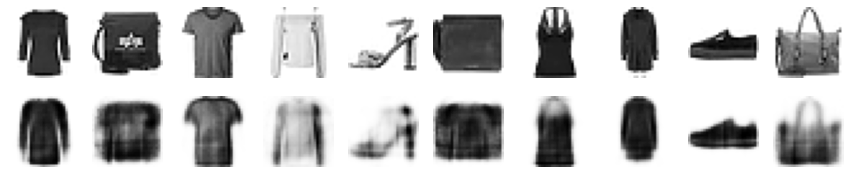

In [20]:
show_reconstructions(stacked_ae_1_by_1)

In [21]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2846 - rounded_accuracy: 0.9364 - val_loss: 0.2863 - val_rounded_accuracy: 0.9364
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2843 - rounded_accuracy: 0.9367 - val_loss: 0.2861 - val_rounded_accuracy: 0.9362
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2842 - rounded_accuracy: 0.9369 - val_loss: 0.2860 - val_rounded_accuracy: 0.9367
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2840 - rounded_accuracy: 0.9370 - val_loss: 0.2858 - val_rounded_accuracy: 0.9368
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2839 - rounded_accuracy: 0.9371 - val_loss: 0.2857 - val_rounded_accuracy: 0.9370
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2838 - rounded_accuracy: 0.9372 - val_loss: 0.2856 - val_rounded_accuracy: 0.9369
Epoch 7/10
1719/1719 [============

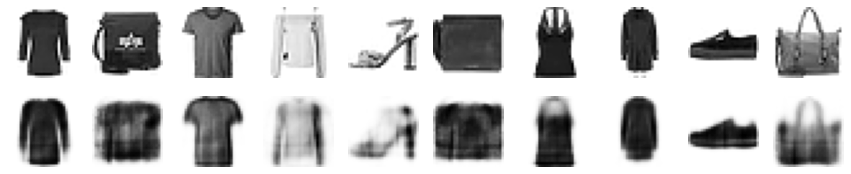

In [22]:
show_reconstructions(stacked_ae_1_by_1)

In [23]:
keras.backend.clear_session()

conv_encoder = keras.models.Sequential([ 
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, 3, padding="same", activation="selu"),
    keras.layers.MaxPooling2D(2),    
    keras.layers.Conv2D(32, 3, padding="same", activation="selu"),
    keras.layers.MaxPooling2D(2),    
    keras.layers.Conv2D(64, 3, padding="same", activation="selu"),
    keras.layers.MaxPooling2D(2),    
])

conv_decoder = keras.models.Sequential([ 
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="valid", activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

conv_auotoencoder = keras.models.Sequential([conv_encoder, conv_decoder])

conv_auotoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

conv_auotoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 8ms/step - loss: 0.3010 - rounded_accuracy: 0.9192 - val_loss: 0.2788 - val_rounded_accuracy: 0.9401
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2755 - rounded_accuracy: 0.9416 - val_loss: 0.2730 - val_rounded_accuracy: 0.9459
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2707 - rounded_accuracy: 0.9464 - val_loss: 0.2694 - val_rounded_accuracy: 0.9499
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2681 - rounded_accuracy: 0.9493 - val_loss: 0.2713 - val_rounded_accuracy: 0.9456
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2662 - rounded_accuracy: 0.9513 - val_loss: 0.2657 - val_rounded_accuracy: 0.9536
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2648 - rounded_accuracy: 0.9528 - val_loss: 0.2689 - val_rounded_accuracy: 0.9461
Epoch 7/10
1719/1719 [============

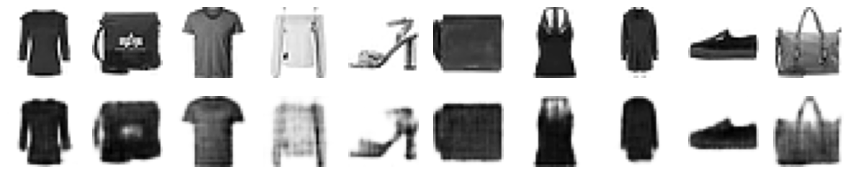

In [24]:
show_reconstructions(conv_auotoencoder)

In [25]:
keras.backend.clear_session()

recurrent_encoder = keras.models.Sequential([ 
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30),
])

recurrent_decoder = keras.models.Sequential([ 
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid")),
])

recurrent_autoencoder = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

recurrent_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

recurrent_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 32s 15ms/step - loss: 0.5086 - rounded_accuracy: 0.7557 - val_loss: 0.4402 - val_rounded_accuracy: 0.8201
Epoch 2/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.4042 - rounded_accuracy: 0.8392 - val_loss: 0.3857 - val_rounded_accuracy: 0.8498
Epoch 3/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3668 - rounded_accuracy: 0.8689 - val_loss: 0.3600 - val_rounded_accuracy: 0.8736
Epoch 4/10
1719/1719 [==============================] - 23s 14ms/step - loss: 0.3523 - rounded_accuracy: 0.8801 - val_loss: 0.3561 - val_rounded_accuracy: 0.8755
Epoch 5/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3420 - rounded_accuracy: 0.8866 - val_loss: 0.3388 - val_rounded_accuracy: 0.8893
Epoch 6/10
1719/1719 [==============================] - 23s 14ms/step - loss: 0.3347 - rounded_accuracy: 0.8912 - val_loss: 0.3330 - val_rounded_accuracy: 0.8898
Epoch 7/10
1719/1719 [======

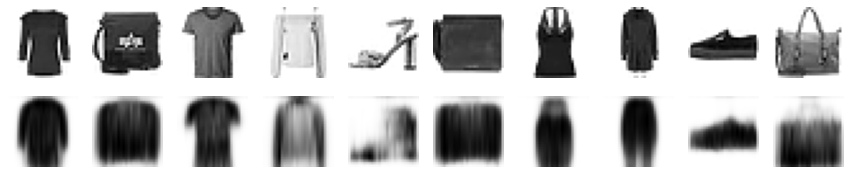

In [26]:
show_reconstructions(recurrent_autoencoder)

In [27]:
keras.backend.clear_session()

denoising_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

denoising_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

denoising_autoencoder = keras.models.Sequential([denoising_encoder, denoising_decoder])

denoising_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

denoising_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3491 - rounded_accuracy: 0.8786 - val_loss: 0.3186 - val_rounded_accuracy: 0.9049
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3127 - rounded_accuracy: 0.9091 - val_loss: 0.3085 - val_rounded_accuracy: 0.9160
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3061 - rounded_accuracy: 0.9146 - val_loss: 0.3040 - val_rounded_accuracy: 0.9189
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3024 - rounded_accuracy: 0.9180 - val_loss: 0.3001 - val_rounded_accuracy: 0.9213
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2999 - rounded_accuracy: 0.9200 - val_loss: 0.2987 - val_rounded_accuracy: 0.9209
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2981 - rounded_accuracy: 0.9217 - val_loss: 0.2986 - val_rounded_accuracy: 0.9246
Epoch 7/10
1719/1719 [============

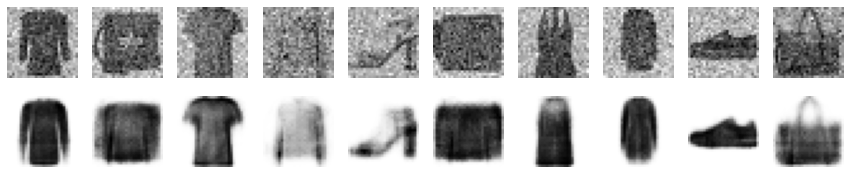

In [28]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_autoencoder, noise(X_valid, training=True))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3547 - rounded_accuracy: 0.8732 - val_loss: 0.3197 - val_rounded_accuracy: 0.9051
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3188 - rounded_accuracy: 0.9028 - val_loss: 0.3117 - val_rounded_accuracy: 0.9113
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3125 - rounded_accuracy: 0.9079 - val_loss: 0.3062 - val_rounded_accuracy: 0.9154
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3086 - rounded_accuracy: 0.9109 - val_loss: 0.3030 - val_rounded_accuracy: 0.9185
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3061 - rounded_accuracy: 0.9129 - val_loss: 0.3013 - val_rounded_accuracy: 0.9185
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3043 - rounded_accuracy: 0.9143 - val_loss: 0.3031 - val_rounded_accuracy: 0.9141
Epoch 7/10
1719/1719 [============

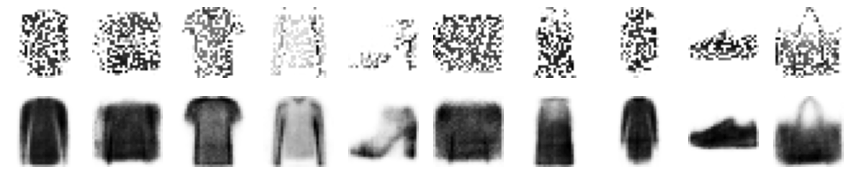

In [29]:
keras.backend.clear_session()

dropout_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

dropout_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

dropout_autoencoder = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

dropout_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_autoencoder, dropout(X_valid, training=True))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4312 - rounded_accuracy: 0.7969 - val_loss: 0.3749 - val_rounded_accuracy: 0.8515
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3595 - rounded_accuracy: 0.8692 - val_loss: 0.3510 - val_rounded_accuracy: 0.8809
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3383 - rounded_accuracy: 0.8889 - val_loss: 0.3310 - val_rounded_accuracy: 0.8951
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3242 - rounded_accuracy: 0.8998 - val_loss: 0.3230 - val_rounded_accuracy: 0.9031
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3193 - rounded_accuracy: 0.9031 - val_loss: 0.3193 - val_rounded_accuracy: 0.9046
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3165 - rounded_accuracy: 0.9053 - val_loss: 0.3169 - val_rounded_accuracy: 0.9078
Epoch 7/10
1719/1719 [============

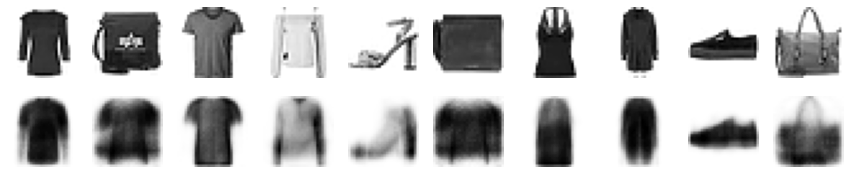

In [30]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

simple_autoencoder = keras.models.Sequential([simple_encoder, simple_decoder])

simple_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.), metrics=[rounded_accuracy])

simple_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

show_reconstructions(simple_autoencoder)

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.4316 - rounded_accuracy: 0.8179 - val_loss: 0.3799 - val_rounded_accuracy: 0.8606
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3695 - rounded_accuracy: 0.8687 - val_loss: 0.3653 - val_rounded_accuracy: 0.8742
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3560 - rounded_accuracy: 0.8785 - val_loss: 0.3513 - val_rounded_accuracy: 0.8834
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3438 - rounded_accuracy: 0.8873 - val_loss: 0.3423 - val_rounded_accuracy: 0.8873
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3365 - rounded_accuracy: 0.8929 - val_loss: 0.3350 - val_rounded_accuracy: 0.8957
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3306 - rounded_accuracy: 0.8978 - val_loss: 0.3329 - val_rounded_accuracy: 0.8939
Epoch 7/10
1719/1719 [============

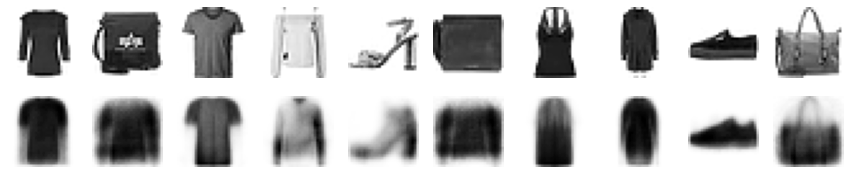

In [31]:
sparse_l1_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3),
])

sparse_l1_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

sparse_l1_autoencoder = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

sparse_l1_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

show_reconstructions(sparse_l1_autoencoder)

In [32]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activities) + kl_divergence(1.0-self.target, 1.0-mean_activities))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4154 - rounded_accuracy: 0.8123 - val_loss: 0.3704 - val_rounded_accuracy: 0.8580
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3517 - rounded_accuracy: 0.8775 - val_loss: 0.3420 - val_rounded_accuracy: 0.8866
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3311 - rounded_accuracy: 0.8950 - val_loss: 0.3263 - val_rounded_accuracy: 0.9001
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3206 - rounded_accuracy: 0.9034 - val_loss: 0.3202 - val_rounded_accuracy: 0.9046
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3163 - rounded_accuracy: 0.9069 - val_loss: 0.3164 - val_rounded_accuracy: 0.9079
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3129 - rounded_accuracy: 0.9098 - val_loss: 0.3134 - val_rounded_accuracy: 0.9112
Epoch 7/10
1719/1719 [============

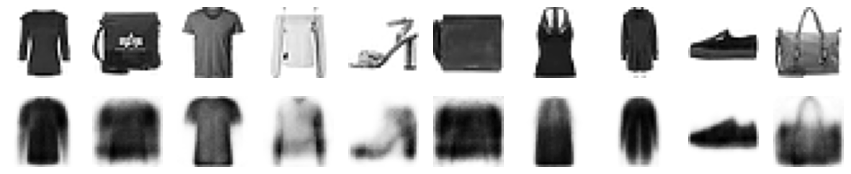

In [33]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg),
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

sparse_kl_autoencoder = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

sparse_kl_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

show_reconstructions(sparse_kl_autoencoder)

In [34]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

In [35]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [36]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [37]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_autoencoder = keras.Model(inputs=[inputs], outputs=[reconstructions])

Epoch 1/10
430/430 [==============================] - 8s 16ms/step - loss: 0.3896 - rounded_accuracy: 0.8610 - val_loss: 0.3510 - val_rounded_accuracy: 0.8913
Epoch 2/10
430/430 [==============================] - 6s 13ms/step - loss: 0.3441 - rounded_accuracy: 0.8964 - val_loss: 0.3495 - val_rounded_accuracy: 0.8933
Epoch 3/10
430/430 [==============================] - 7s 15ms/step - loss: 0.3336 - rounded_accuracy: 0.9044 - val_loss: 0.3387 - val_rounded_accuracy: 0.8968
Epoch 4/10
430/430 [==============================] - 6s 14ms/step - loss: 0.3284 - rounded_accuracy: 0.9087 - val_loss: 0.3288 - val_rounded_accuracy: 0.9106
Epoch 5/10
430/430 [==============================] - 5s 12ms/step - loss: 0.3251 - rounded_accuracy: 0.9112 - val_loss: 0.3279 - val_rounded_accuracy: 0.9127
Epoch 6/10
430/430 [==============================] - 6s 14ms/step - loss: 0.3227 - rounded_accuracy: 0.9132 - val_loss: 0.3224 - val_rounded_accuracy: 0.9135
Epoch 7/10
430/430 [==========================

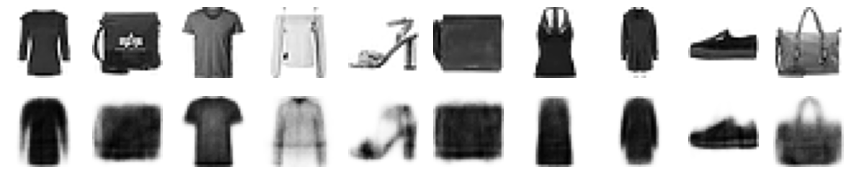

In [38]:
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_autoencoder.add_loss(K.mean(latent_loss) / 784.)

variational_autoencoder.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, validation_data=(X_valid, X_valid))

show_reconstructions(variational_autoencoder)

In [39]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

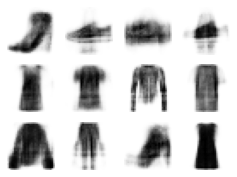

In [40]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

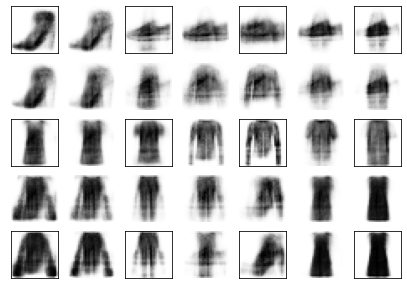

In [41]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

In [42]:
codings_size = 30

generator = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [43]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [44]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

Epoch 1/3


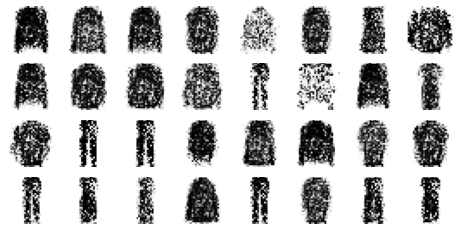

Epoch 2/3


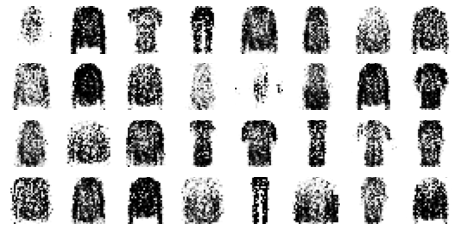

Epoch 3/3


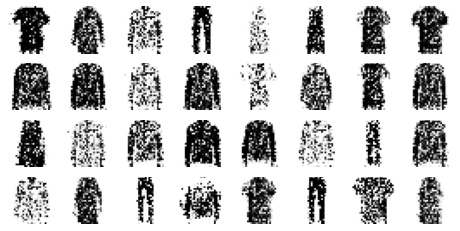

In [45]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=3)

In [46]:
keras.backend.clear_session()

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, 5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, 5, strides=2, padding="same", activation="tanh"),
])

discriminator = keras.models.Sequential([ 
    keras.layers.Conv2D(64, 5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, 5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid"),
])

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [47]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [48]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/3


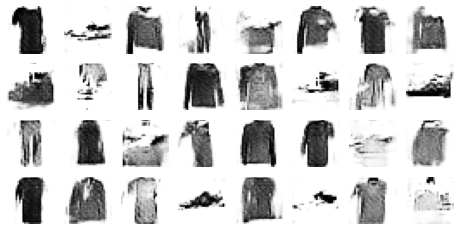

Epoch 2/3


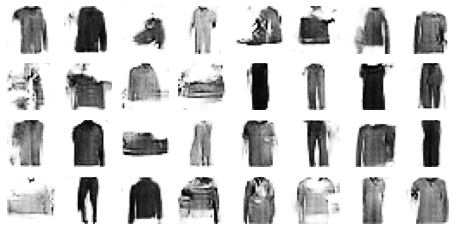

Epoch 3/3


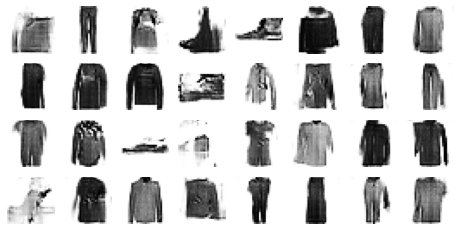

In [49]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=3)

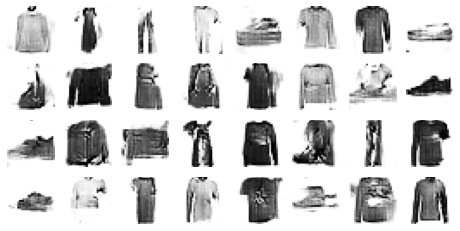

In [50]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

In [51]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

Conv2DTranspose output shape 계산 그냥 공식대로 하셈
이해하려고 하면 너무 복잡해서 착한 케라스님들이 공식정해줌
대강 하셈 ㅡㅡ

In [52]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [56]:
keras.backend.clear_session()

hashing_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])

hashing_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

hashing_autoencoder = keras.models.Sequential([hashing_encoder, hashing_decoder])

hashing_autoencoder.compile(loss="binary_crossentropy", optimizer="Nadam", metrics=[rounded_accuracy])

hashing_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4058 - rounded_accuracy: 0.8145 - val_loss: 0.3864 - val_rounded_accuracy: 0.8258
Epoch 2/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3647 - rounded_accuracy: 0.8515 - val_loss: 0.3650 - val_rounded_accuracy: 0.8452
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3544 - rounded_accuracy: 0.8618 - val_loss: 0.3601 - val_rounded_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3499 - rounded_accuracy: 0.8662 - val_loss: 0.3529 - val_rounded_accuracy: 0.8631
Epoch 5/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3470 - rounded_accuracy: 0.8691 - val_loss: 0.3477 - val_rounded_accuracy: 0.8686
Epoch 6/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3447 - rounded_accuracy: 0.8717 - val_loss: 0.3457 - val_rounded_accuracy: 0.8740
Epoch 7/10
1719/1719 [======

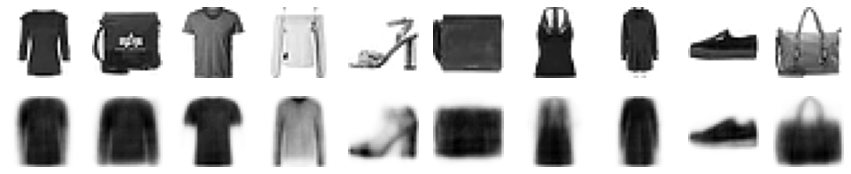

In [57]:
show_reconstructions(hashing_autoencoder)

In [58]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

1001100101101000
0001100101100000
1001110101100000
0100100001001000
0000000000000101
...


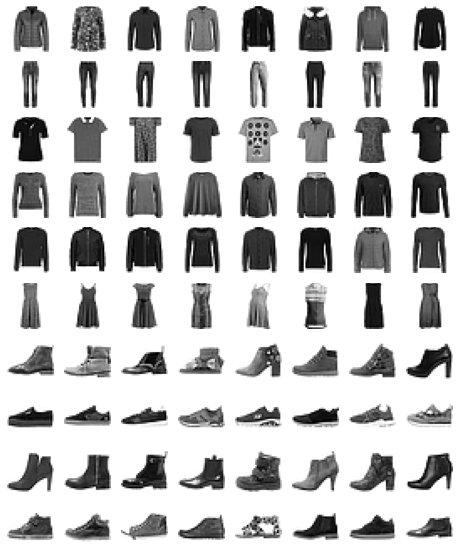

In [59]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")